# Association between Fertility & Local Municipal Characteristics in Denmark 

### Imports

In [106]:
import geopandas as gpd # for geospatial data handling
import pandas as pd
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [107]:
# load the saved GeoDataFrame from file
gdf = gpd.read_file('Data/gdf.geojson')

In [108]:
# index gdf on the municipal_id
gdf = gdf.set_index("municipal_id", drop=False)

## Inspecting spatial data and EDA

## Spatial Weights

In [109]:
import seaborn as sns
sns.set_theme()
from pysal.lib import weights
from libpysal.io import open as psopen
import numpy as np
import matplotlib.pyplot as plt
from splot.libpysal import plot_spatial_weights

In [110]:
gdf.info

<bound method DataFrame.info of               municipality_nm fer_rate live_birth  edu_att market_val  \
municipal_id                                                            
101                 København    15639     10 285  501 212  2 399 736   
147             Frederiksberg    17878      1 534   74 788  3 435 510   
155                    Dragør    25109        146    9 074  4 014 690   
185                    Tårnby    20567        473   28 727  2 823 345   
165               Albertslund    16087        274   18 664  2 931 561   
...                       ...      ...        ...      ...        ...   
773                     Morsø    20807        180   13 103  1 321 820   
840                    Rebild    24005        380   20 166  1 997 252   
787                   Thisted    20638        410   28 630  1 422 277   
820           Vesthimmerlands    18244        314   24 005  1 495 512   
851                   Aalborg    16043      2 488  158 831  2 042 461   

             kommu

Under the queen criteria, two observations only need to share a vortex (a single point) of their boundaries to be considered neighbors. 

WHICH weight matrix should we use? 

In your case, since you are interested in the association between fertility and local municipal characteristics in Denmark, you could consider using a queen contiguity weight matrix as a starting point. This method considers each observation's direct neighbors (those sharing an edge or a vertex) as "similar" and assigns them a weight of 1, while observations that are not adjacent are assigned a weight of 0. This method is a good choice when you want to capture the spatial autocorrelation of the data while also considering spatial relationships beyond immediate physical proximity.

However, it is always a good idea to experiment with different weight matrix methods and compare their results to determine the most appropriate method for your specific research question and data.

In [111]:
w_queen = weights.Queen.from_dataframe(gdf, idVariable="municipal_id")

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 8 islands with ids: 219, 420, 430, 492, 530, 573, 787, 820.
  warnings.warn(message)


However, the cell where we computed $w_queen$ returned a warning on "islands". Remember these are islands not necessarily in the geographic sense (although some of them will be), but in the mathematical sense of the term: local authorities that are not sharing border with any other one and thus do not have any neighbors. As we saw last time, we can inspect and map them to get a better sense of what we are dealing with:

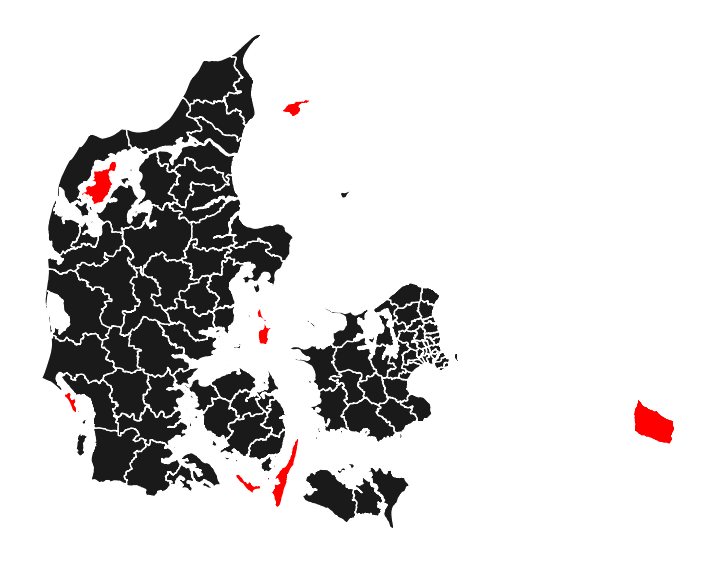

In [112]:
ax = gdf.plot(color='k', figsize=(9, 9))
gdf.loc[w_queen.islands, :].plot(color='red', ax=ax)
ax.set_axis_off()

Attribute 'cardinalities' gives as a direct access to the number of neighbors each observation has

In [113]:
# row standardize the matrix to make sure every row od the matrix sums up to 1
w_queen.transform = 'R'

('WARNING: ', 219, ' is an island (no neighbors)')
('WARNING: ', 420, ' is an island (no neighbors)')
('WARNING: ', 430, ' is an island (no neighbors)')
('WARNING: ', 492, ' is an island (no neighbors)')
('WARNING: ', 530, ' is an island (no neighbors)')
('WARNING: ', 573, ' is an island (no neighbors)')
('WARNING: ', 787, ' is an island (no neighbors)')
('WARNING: ', 820, ' is an island (no neighbors)')


In [114]:
queen_card = pd.Series(w_queen.cardinalities)
queen_card.head()

101    4
147    3
151    4
153    6
155    3
dtype: int64

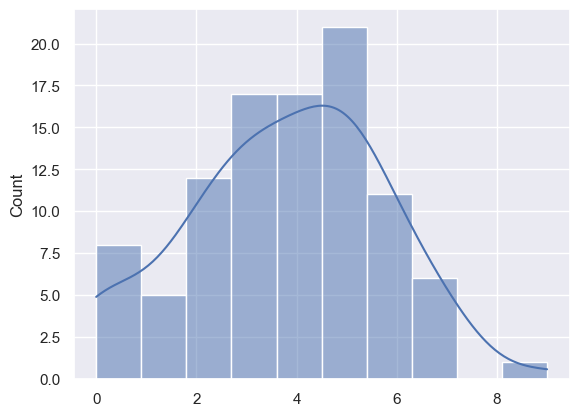

In [115]:
sns.histplot(queen_card, bins=10, kde=True); # stat="density"

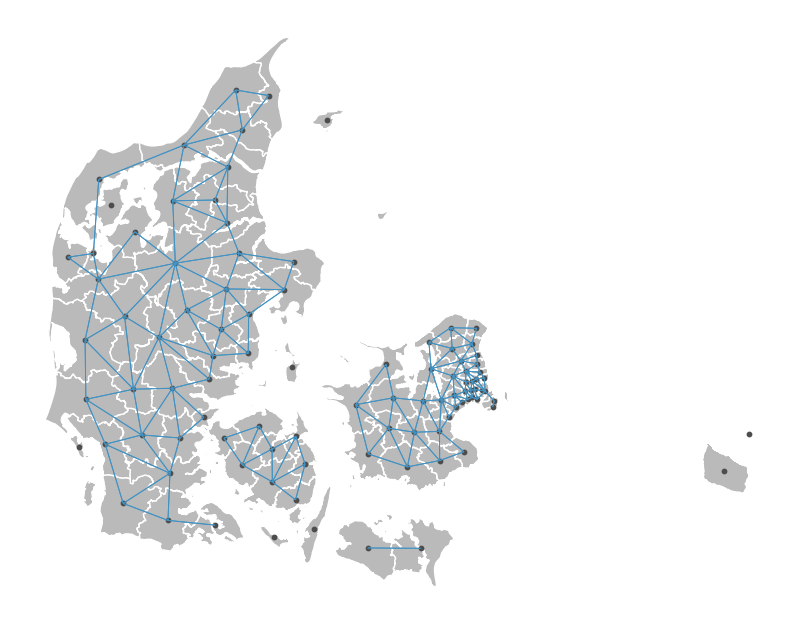

In [116]:
plot_spatial_weights(w_queen, gdf, indexed_on="municipal_id");

## Spatial Autocorrelation

In [117]:
import seaborn as sns
import pandas as pd
import esda
from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights
import geopandas as gpd
import numpy as np
import contextily as cx
import matplotlib.pyplot as plt

In [118]:
type(gdf['fer_rate'])

pandas.core.series.Series

In [119]:
# gdf['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave']) # we pass the weights object and the column with values to base the spatial lag on
gdf['w_fer_rate'] = weights.lag_spatial(w_queen, gdf['fer_rate']) # we pass the weights object and the column with values to base the spatial lag on

TypeError: no supported conversion for types: (dtype('float64'), dtype('O'))